In [27]:
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Statistics
using Interpolations
using PyPlot
using MAT
using JLD2

# include("../mast/readers.jl")
# using .ShipPosmv

  Activating project at `~/Projects/ASTRAL/lidar`


from file: vectornav.h

#define IDX_TIMEGPS 0
#define IDX_YAW 1
#define IDX_PITCH 2
#define IDX_ROLL 3
#define IDX_QUAT0 4
#define IDX_QUAT1 5
#define IDX_QUAT2 6
#define IDX_QUAT3 7
#define IDX_LATITUDE 8
#define IDX_LONGITUDE 9
#define IDX_ALTITUDE 10
#define IDX_MAGNED0 11
#define IDX_MAGNED1 12
#define IDX_MAGNED2 13
#define IDX_LINACC0 14
#define IDX_LINACC1 15
#define IDX_LINACC2 16
#define IDX_VELNED0 17
#define IDX_VELNED1 18
#define IDX_VELNED2 19

from file:  vectornav.cpp

  shared_memory->name(
    "GpsTime",
    "Yaw", "Pitch", "Roll",
    "Quat0", "Quat1", "Quat2", "Quat3",
    "Latitude", "Longitude", "Altitude",
    "MagNED0", "MagNED1", "MagNED2",
    "LinAcc0", "LinAcc1", "LinAcc2",
    "VelNED0", "VelNED1", "VelNED2");

To decode these variables, you need to look at the VectorNav variable description located in \ceees-lidar-platform-master\lib-src\vnproglib-1.1\index.html
under sensor class.

In [2]:
# function to read the VectorNav file
# line:
# Tue Mar 28 13:17:11 2023 +0000, 9431257000, -163.267792, -1.067281, -1.441135, -0.011044, 0.011087, -0.989255, 0.145364, 0.000000, 0.000000, 0.000000, 0.234963, -0.005458, 0.101274, 0.432598, -0.534912, -9.797964, 0.000000, 0.000000, 0.000000
#
# 21 science data fields delimited by commas

function read_vevnav_data( file )
    # allocate arrays
    nlmax = countlines(file)
    dt = Vector{DateTime}(undef, nlmax)
    intdata = Matrix{Int64}(undef, nlmax, 2)
    data = Matrix{Float32}(undef, nlmax, 19)

    # read it >>BLACK PUMAS<<
    nl = 0
    df = dateformat"uuuHH:MM:SSyyyy"
    open( file ) do f
        for line in readlines(f)
            # Tue Mar 28 13:17:11 2023 +0000, 9431257000, -163.267792, -1.067281, -1.441135, -0.011044, 0.011087, -0.989255, 0.145364, 0.000000, 0.000000, 0.000000, 0.234963, -0.005458, 0.101274, 0.432598, -0.534912, -9.797964, 0.000000, 0.000000, 0.000000
            nl += 1
            spl = split(line, r"[\ ,]+")
            try
                dt[nl] = ( 
                    DateTime(spl[2], dateformat"u") + Day(parse(Int8, spl[3])) 
                  + Year(parse(Int16, spl[5])-1) 
                  +(DateTime(spl[4], dateformat"HH:MM:SS") - DateTime(1,1,1)) )
                intdata[nl,:] .= parse.(Int64, spl[6:7])  #  2
                data[nl,:] .= parse.(Float32, spl[8:end]) # 19
            catch
                @show line
            end
        end
    end
    return dt[1:nl], intdata[1:nl,:], data[1:nl,:]
end

function read_vecnav_dict( file )

    D = Dict{Symbol, Any}()
    vnkeys = Symbol.( [
    "Yaw", "Pitch", "Roll",
    "Quat0", "Quat1", "Quat2", "Quat3",
    "Latitude", "Longitude", "Altitude",
    "MagNED0", "MagNED1", "MagNED2",
    "LinAcc0", "LinAcc1", "LinAcc2",
    "VelNED0", "VelNED1", "VelNED2" ] )

    dt, gpstime, data = read_vevnav_data( file )

    D[:time] = dt
    D[:GpsTime] = gpstime[:,2]
    for (i,k) in enumerate(vnkeys)
        D[k] = data[:,i]
    end
    return D
end


read_vecnav_dict (generic function with 1 method)

In [3]:
# precompile reader on a short file
test = read_vecnav_dict( "./data/lidar/table/VNshort.txt" ) 

Dict{Symbol, Any} with 21 entries:
  :LinAcc1   => Float32[-0.534912, 0.242155, -0.252161, -0.142886, 0.870555, -0…
  :Roll      => Float32[-1.44114, -1.4784, -1.4599, -1.51939, -1.4881, -1.55684…
  :Latitude  => Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.…
  :Yaw       => Float32[-163.268, -163.09, -163.29, -163.131, -163.282, -163.13…
  :time      => [DateTime("2023-03-29T13:17:11"), DateTime("2023-03-29T13:17:11…
  :VelNED1   => Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.…
  :MagNED2   => Float32[0.101274, 0.102987, 0.101529, 0.10302, 0.101723, 0.1018…
  :Altitude  => Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.…
  :Quat1     => Float32[0.011087, 0.011421, 0.011312, 0.011824, 0.01162, 0.0122…
  :VelNED2   => Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.…
  :MagNED0   => Float32[0.234963, 0.238538, 0.237532, 0.239332, 0.240921, 0.241…
  :Quat0     => Float32[-0.011044, -0.010909, -0.010645, -0.010649, -0.010

In [4]:
# read whole VecNav data file
datadir = "./data/lidar/table/"
file = joinpath(datadir, "VectorNavTableData.txt")



"./data/lidar/table/VectorNavTableData.txt"

In [ ]:
bigread = false

if bigread
    # precompile reader on a short file
    @time test = read_vecnav_dict( "./data/lidar/table/VNshort.txt" ) 
    @time test = read_vecnav_dict( "./data/lidar/table/VNshort.txt" ) 

    # process the big read Vn data

    # study time index
    @time Vn = read_vecnav_dict( file ) # very big slow read takes 2:27; !compile first!
    plot(Vn[:GpsTime][1200:1200:end], marker=".", linestyle="none") # jumps
    plot(Vn[:time][1200:1200:end], marker=".", linestyle="none") # monotonic
    i0 = findfirst(diff(Vn[:GpsTime][:]) .> 1e17)+1
    # i0=663 # first good index of big Vn structure

    # diff(Vn[:GpsTime][700:712]) # integer nanoseconds = 10-9 s
    # 50_000_000 ns is 0.05 s

    function gps2dt(gpstime::Integer)
        t_d = floor(gpstime / (86_400 * 1_000_000_000)) # nanosecond -> integer day
        t_ms = round(Int64, (gpstime % (86_400 * 1_000_000_000) ) / 1_000_000) # nansecond -> millisecond of day
        DateTime(1980, 1, 6, 0,0,0) + Day(t_d) + Millisecond(t_ms)
    end
    gps2dt(gpstime::Vector) = gps2dt.(gpstime)

    # fix the time
    delete!(Vn, :time)
    Vn[:time] = gps2dt(Vn[:GpsTime]) # re-add

    # time interpolator, truncates
    itp_vn(k, t) = interpolate(Dates.value.(Vn[:time][i0:end]), Vn[k][i0:end])[t]

    # write in a mat file
    matopen("VectorNavTable.mat", "w") do matfile
        # Write the variables to the MAT file
        write(matfile, "time_offset", Dates.value.(Vn[:time][i0:end] .- Vn[:time][i0])) # millisec since base_time
        write(matfile, "base_time",  Dates.format( Vn[:time][i0], "yyyy-mm-dd HH:MM:SS.sss" ))
        for k in filter(k -> k !== :time, keys(Vn))
            write(matfile, String(k), Vn[k][i0:end])
        end
        close(matfile)
    end

    # write 1 JLD2 file
    jldopen("VectorNavTable.jld2", "w") do file
        # Write the VectorNav dict to the JLD2 file
        file["Vn"] = Vn
    end

    # read 1 big JLD2 file 
    jldopen("VectorNavTable.jld2", "r") do file # subsetting while reading saves no time
        vn_dt = file["Vn"][:time]
        pitch = file["Vn"][:Pitch]   # degrees 
        roll  = file["Vn"][:Roll]    # degrees
        heave = file["Vn"][:VelNED2] # m/s
    end

    # save smaller subsets as daily files for easier reading
    days = unique(Date.(Vn[:time][i0:end]))

    for d in days
        st = maximum(i0, findfirst(t -> t >= d, vn_dt ))
        en = findlast( t -> t <  d+Day(1), vn_dt )
        yyyymmdd = Dates.format(d, dateformat"yyyymmdd")

        jldopen(joinpath(datadir, "VectorNavTable_$(yyyymmdd).jld2"), "w") do file
            # Write the VectorNav dict to the JLD2 file
            file["time"]  = vn_dt[st:en]
            file["pitch"] = pitch[st:en]
            file["roll"]  =  roll[st:en]
            file["heave"] = heave[st:en]
        end
    end

end

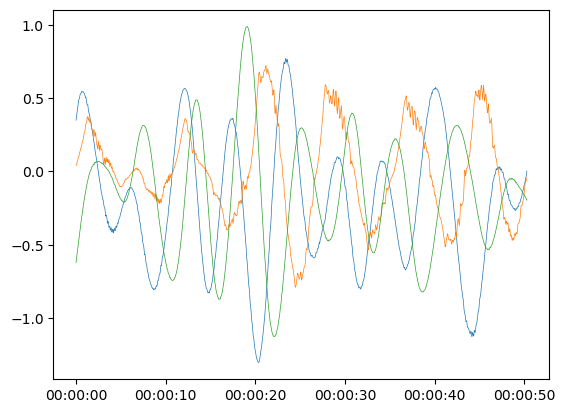

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x3493bffd0>

In [16]:
# read daily JLD2 example
dt = DateTime(2024, 5, 8)
yyyymmdd = Dates.format(dt, dateformat"yyyymmdd")
Vn = JLD2.load(joinpath(datadir, "VectorNavTable_$(yyyymmdd).jld2"))

st = 1; en = 1000
plot(Vn["time"][st:en], Vn["roll"][st:en], linewidth=0.5) # RollPitchYaw in degrees
plot(Vn["time"][st:en], Vn["pitch"][st:en], linewidth=0.5)
plot(Vn["time"][st:en], Vn["heave"][st:en], linewidth=0.5) # heave of the body in NED frame in m/s

## find displacements of sample volumes

In [24]:
rangegate = 24
range = 12.0 .+ 24.0.*((1:150).-1) # conflicts with Base.range

#=
heave = Vn[:VelNED2] # m/s?

# trigonometry to find displacements between volumes to be used in structure functions
target_vector(range, pitch, roll) = range .* [ -sin(pitch), cos(pitch)*sin(roll), cos(pitch)*cos(roll) ]
#simultaneous_vector(a1,a2, p1,p2, r1,r2) = target_vector(a1,p1,r1) .- target_vector(a2,p2,r2)
displacement_vector(X, Y, a1,a2, p1,p2, r1,r2) = [X, Y, 0] .- (target_vector(a1,p1,r1) .- target_vector(a2,p2,r2))
rad = abs(displacement_vector)
r1 = abs(displacement_vector[1])

function df(f, x::Vector)
    y = 
    for i = axes(x)
        for j = axes(x)[1:end]
            y = f( x[i] - x[j] )
        end
    end
    return y
end

"efficient representation of interaction of difference of vector u members"
Df(u) = UpperTriangular( (u .- permutedims(u)) )

# vectorize 3 levels of w
D2w = Df(w).^2
dx  = Df(x)
dy  = Df(y)
dz  = Df(z)
dist3 = norm()
=#

12.0:24.0:3588.0

In [19]:
#=
# address the time,height series with CartesianIndices?
ntime = 1000
nz = 150
nzoffset = 3
nind = ntime*(ntime+1)/2 * (nzoffset*nz - nzoffset*(nzoffset-1)/2)

function displacements_housekeeping(dt=0.5, range=12.0.+24.0.*((1:150).-1), U=10, V=10)
    ntime = 1000
    nz = 150
    nzoffset = 3
    nind = round(Int64, ntime*(ntime+1)/2 * (nzoffset*nz - nzoffset*(nzoffset-1)/2))
    
    # first housekeeping pass to estimate indices and displacements without data
    # and no angular corrections

    I = Vector{CartesianIndex{2}}(undef, nind)
    J = Vector{CartesianIndex{2}}(undef, nind)
    fill!(I, CartesianIndex(0,0))
    fill!(J, CartesianIndex(0,0))

    zm = Vector{Union{Missing,Float32}}(missing, nind)
    dz = Vector{Union{Missing,Float32}}(missing, nind)
    dr = Vector{Union{Missing,Float32}}(missing, nind)
    
    pitch = 0
    roll = 0
    X = 0.5
    Y = 0.5

    lin = 0 
    for it in 1:ntime
        for jt in (it+1):ntime # operate with all subsequent times
            for iz in 1:nz-2
                for jz in (iz+1):min(ntime, iz+2) # operate with next 3 levels
                    lin += 1
                    # I is first point, J is second point
                    I[lin] = CartesianIndex(it,iz)
                    J[lin] = CartesianIndex(it,jz)
                    zm[lin] = (range[iz] + range[jz]) / 2
                    dz[lin] =  range[iz] - range[jz]
                    dx = X
                    dy = Y
                    # distance between
                    dr[lin] = dz[lin]*dz[lin] + dx*dx * dy*dy
                end
            end
        end
    end

    return I,J, zm, dz,dr, lin
end

I,J, zm, dz,dr, lin = displacements_housekeeping()
# still not sure I'm counting the pairs correctly
=#

(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 2), CartesianIndex(1, 2), CartesianIndex(1, 3), CartesianIndex(1, 3), CartesianIndex(1, 4), CartesianIndex(1, 4), CartesianIndex(1, 5), CartesianIndex(1, 5)  …  CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0)], CartesianIndex{2}[CartesianIndex(1, 2), CartesianIndex(1, 3), CartesianIndex(1, 3), CartesianIndex(1, 4), CartesianIndex(1, 4), CartesianIndex(1, 5), CartesianIndex(1, 5), CartesianIndex(1, 6), CartesianIndex(1, 6), CartesianIndex(1, 7)  …  CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0), CartesianIndex(0, 0)], Union{Missing, Float32}[24.0f0, 36.0f0, 48.0f0, 60.0f0, 72.0f0, 84.0f0, 96.

In [216]:
nt = 1000
nc = 3

# construct the indices of the combination sets
ci = CartesianIndices((nt,nc))
li = LinearIndices(ci)

# Generate the set of unique pairs of indices (l1,l2)
# where l1 < l2.
# Set() makes unique but it's slow and the result of the comprehension is already unique. 
lpairs = [ (l1, l2) for l1 in li[:] for l2 in (l1+1):last(li) ]
l1 = first.(lpairs) # vector of linear indices to points 1 of pairs
l2 =  last.(lpairs) #                             points 2
# str_fcn = w[ci[l1]] - w[ci[l2]])

# w can be indexed directly with ci[first.(lpairs])
# unpack the CartesianIndex to subscript the time, range
# idx[1] works but first(idx) tries to iterate which is unsupported
it1 = map(idx->idx[1], ci[l1]) #  t index of first point(s)
iz1 = map(idx->idx[2], ci[l1]) #  z index of first
it2 = map(idx->idx[1], ci[l2]) #  t       of second points(s)
iz2 = map(idx->idx[2], ci[l2]) #  z          second
#     first.(Tuple.(ci[l1])) # this also works


4498500-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3

In [20]:
# It might be fast enough to just move the pairing window up by 1 each time.
# But this will repeat some sample pairs: pairs in adjacent lines 2x, and in the same line 3x.
# To fix this, compute the unique set of pairs l1,l2 for the whole set of CartesianIndices 
# including z indices 1:nz. Then filter for the z index of ci[l2] to be <=3 from ci[l1].
# Generating this many pair is awfully slow. 
# There's no overlap if we generate pairs in sets of 3 levels, and go back to fill
## ci = CartesianIndices((nt,nz)) ## too slow

nt = 1000
nc = 3
islide = 0
ci = CartesianIndices((nt,nc)) .+ CartesianIndex((0, islide))
li = LinearIndices(ci)
lpairs = [ (l1, l2) for l1 in li[:] for l2 in (l1+1):last(li) ] # redundancy

# The right complete set that doesn't repeat pairs is 
# 1 the complete set of nt*(n-1)/2 pairs for the top level (3)
# 2 the 2*nt*nt sets of pairs between every point in top (3) level and the next 2 levels
# Iteratively slide this box upward by 1 level for each level.
"index unique pairs in a vector of length n"
function uniquepairs(n) 
    [ [l1, l2] for l1 in 1:n for l2 in (l1+1):n ]
end
"index pairs of points in adjacent levels"
allcross(n) = [ [l1, l2] for l1 in 1:n for l2 in 1:n ]

# index pairs in middle level 2-2
up = uniquepairs(nt)
it1 = map(i->i[1], up) # time indices for pairs of point1, point2
it2 = map(i->i[2], up)
ci1_r22 = CartesianIndex.(tuple.(it1,2)) # 1st point in pair lev
ci2_r22 = CartesianIndex.(tuple.(it2,2)) # 2nd 

# index pairs of points from level 2-1, and 2-3
ac = allcross(nt)
it1 = map(i->i[1], ac)
it2 = map(i->i[2], ac)
ci1_r21 = ci1_r23 = CartesianIndex.(tuple.(it1,2))
ci2_r21 = CartesianIndex.(tuple.(it2,1))
ci2_r23 = CartesianIndex.(tuple.(it2,3))

# omnibus set of cartesian index pairs for a level, including points in lev above and below
ci1 = [ci1_r23; ci1_r22; ci1_r21] # first of pairs
ci2 = [ci2_r23; ci2_r22; ci2_r21]
li1 = LinearIndices(ci1)
li2 = LinearIndices(ci2)

2499500-element LinearIndices{1, Tuple{Base.OneTo{Int64}}}:
       1
       2
       3
       4
       5
       6
       7
       8
       9
      10
      11
      12
      13
       ⋮
 2499489
 2499490
 2499491
 2499492
 2499493
 2499494
 2499495
 2499496
 2499497
 2499498
 2499499
 2499500

In [74]:
# just use one level
up = uniquepairs(nt)
it1 = map(i->i[1], up) # time indices for pairs of point1, point2
it2 = map(i->i[2], up)
ci1_r11 = CartesianIndex.(tuple.(it1,1)) # 1st point in pair lev
ci2_r11 = CartesianIndex.(tuple.(it2,1)) # 2nd 

# set of cartesian index pairs for a level, including points in lev above and below
ci1 = ci1_r11 # first of pairs
ci2 = ci2_r11
li1 = LinearIndices(ci1)
li2 = LinearIndices(ci2)

499500-element LinearIndices{1, Tuple{Base.OneTo{Int64}}}:
      1
      2
      3
      4
      5
      6
      7
      8
      9
     10
     11
     12
     13
      ⋮
 499489
 499490
 499491
 499492
 499493
 499494
 499495
 499496
 499497
 499498
 499499
 499500

In [75]:
it1 = map(idx->idx[1], ci1) #  t index of first point(s)
iz1 = map(idx->idx[2], ci1) #  z index of first
it2 = map(idx->idx[1], ci2) #  t       of second points(s)
iz2 = map(idx->idx[2], ci2) #  z          second

499500-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [76]:
# nominal displacements with no pitch-roll corrections

"""
zm, dr2, dz2, D2 = displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate)
Displacements of sample pairs for one (vertical) subvolume.
"""
function displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate)
    # get the individual indices
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second

    rng(iz) = rangegate * (iz-1 + 0.5) # center of gates

    # horiz translation by mean wind
    Udtbar = @. (Udt[iz2] + Udt[iz1]) / 2
    Vdtbar = @. (Vdt[iz2] + Vdt[iz1]) / 2
    X = @. Udtbar * (it2 - it1)
    Y = @. Vdtbar * (it2 - it1)
    # vertical middle of pair
    zm = @. (rng(iz2) * cos(pitch[it2])*cos(roll[it2]) + rng(iz1) * cos(pitch[it1])*cos(roll[it1])) / 2
    # displacement between pair of points
    dz = @.     rng(iz2) * cos(pitch[it2])*cos(roll[it2]) - rng(iz1) * cos(pitch[it1])*cos(roll[it1])
    dx = @. X + rng(iz2) *-sin(pitch[it2])                - rng(iz1) *-sin(pitch[it1])
    dy = @. Y + rng(iz2) * cos(pitch[it2])*sin(roll[it2]) - rng(iz1) * cos(pitch[it1])*sin(roll[it1])
    # distance between
    dz2 = dz .* dz
    dr2 = @. dz2 + dx*dx + dy*dy
    # vel structure function
    D2 = @. (w[ci2] - w[ci1])^2
    # return properties of pairs
    return zm, dr2, dz2, D2
end

"dr^2/3 (1-(dz/dr)^2/4) displacement function for computing dissipation from structure function pairs"
rhopair(dr2, dz2) = dr2^(1/3) * (1 - dz2/(4*dr2))

rhopair

In [77]:
# test the logic by computing with dummy data
nz = 150
w = zeros(nt,nz)
Udt = 5.0 .+ zeros(nz)
Vdt = 5.0 .+ zeros(nz)
pitch = @. 10*pi/180 * sin((1:nt)*pi/10) # fake
roll  = @. 10*pi/180 * cos((1:nt)*pi/10)

zm, dr2, dz2, D2 = displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate )


([11.817982128203518, 11.817982128203518, 11.817852842269513, 11.817772939208005, 11.817852842269513, 11.817982128203518, 11.817982128203518, 11.817852842269515, 11.817772939208005, 11.817852842269513  …  11.817982128203516, 11.817982128203516, 11.817852842269513, 11.817772939208005, 11.818111414137519, 11.817982128203516, 11.817902225142007, 11.817982128203516, 11.817902225142007, 11.817772939208005], [41.60892235148373, 165.56618916638564, 373.2530801612619, 669.3141843344615, 1060.9511284580296, 1556.997976965279, 2166.808405320483, 2898.900254753664, 3759.4234181093752, 4750.7572886879725  …  53.26818337860324, 207.41469221877617, 453.76540289876505, 784.54262777845, 50.45958740461272, 196.0943665565296, 428.95391361097325, 47.60838001704101, 185.1729869202623, 44.99943919594262], [6.685941092315753e-8, 6.685941092315753e-8, 3.1554436208840472e-30, 2.5537996954371423e-8, 3.1554436208840472e-30, 6.685941092315753e-8, 6.685941092315753e-8, 0.0, 2.5537996954371423e-8, 3.15544362088404

In [97]:
rho = rhopair.(dr2, dz2)
#plot((1:length(rho))/length(rho), sort(rho))

# devise equally-populated bins
nrho = length(rho)
nbin = 20
sp = sortperm(rho)
srho = rho[sp]
rhobins = [ 0; rho[sp[Int32(nrho/20):Int32(nrho/20):nrho]] ]
# maximum(rho), sort(rho)[length(rho)]
# plot(rhopair.(dr2, dz2), zm, marker=".", linestyle="none")
# hist(rhopair.(dr2, dz2), bins=20)

# bin average y in bins of x
function binavg(y, x, b)
    a = zeros(length(b))
    c = zeros(length(b))
    for (i,x) in enumerate(x)
        bi = findlast(j -> j < x, b)
        a[bi] += y[i]
        c[bi] += 1
    end
    return a./c
end

D2bin = binavg(rand(length(rho)), rho, rhobins)

21-element Vector{Float64}:
   0.5011519448338186
   0.4999114056422025
   0.502889482573963
   0.5024909566945889
   0.5021074583191569
   0.4990818258293421
   0.5016916866736525
   0.5029742832878987
   0.4985054101735766
   0.5022302415769619
   0.4979960591945028
   0.5039502632839588
   0.5006210530627802
   0.5003313080284651
   0.5020551011563921
   0.5025498290622787
   0.5003079689029826
   0.5000752475035021
   0.49981572721669687
   0.5004674802523021
 NaN

In [ ]:

# plot some of this stuff
# drcount, bins = hist((dr[:]), bins=80, range=(30, (X*nt*1.4)))
dzcount, bins = hist((dz[:]), bins=80, range=(0, (2*24)))
title("displacement between point pairs")
clf()
plot(dz./dr, dz, marker=".", linestyle="none")


In [ ]:

    dz = Float32
    for it in 1:ntime
        for jt in (it+1):ntime # operate with all subsequent times
            for iz in 1:nz-2
                for jz in (iz+1):min(ntime, iz+2) # operate with next 3 levels
                    # i is first point, j is second point

                    # mean wind translation
                    X = U * dt*(jt-it)
                    Y = V * dt*(jt-it)
                    # middle of pair
                    zm =    (range[iz] * cos(pitch[it])*cos(roll[it]) + range[jz] * cos(pitch[jt])*cos(roll[jt])) / 2
                    # displacement between pair of points
                    dz =     range[iz] * cos(pitch[it])*cos(roll[it]) - range[jz] * cos(pitch[jt])*cos(roll[jt])
                    dx = X + range[iz] *-sin(pitch[it])               - range[jz] *-sin(pitch[jt])
                    dy = Y + range[iz] * cos(pitch[it])*sin(roll[it]) - range[jz] * cos(pitch[jt])*sin(roll[jt])
                    # distance between
                    dr = dz*dz + dx*dx * dy*dy
                    # vel structure function
                    D2 = (w[it,iz] - w[jt,jz])^2
                end
            end
        end
    end
end

function displacements_D2(dt=0.5, range=12.0.+24.0.*((1:150).-1), U=10, V=10)
    for it in 1:ntime
        for jt in (it+1):ntime # operate with all subsequent times
            for iz in 1:nz-2
                for jz in (iz+1):min(ntime, iz+2) # operate with next 3 levels
                    # i is first point, j is second point

                    # mean wind translation
                    X = U * dt*(jt-it)
                    Y = V * dt*(jt-it)
                    # middle of pair
                    zm =    (range[iz] * cos(pitch[it])*cos(roll[it]) + range[jz] * cos(pitch[jt])*cos(roll[jt])) / 2
                    # displacement between pair of points
                    dz =     range[iz] * cos(pitch[it])*cos(roll[it]) - range[jz] * cos(pitch[jt])*cos(roll[jt])
                    dx = X + range[iz] *-sin(pitch[it])               - range[jz] *-sin(pitch[jt])
                    dy = Y + range[iz] * cos(pitch[it])*sin(roll[it]) - range[jz] * cos(pitch[it1])*sin(roll[jt])
                    # distance between
                    dr = dz*dz + dx*dx * dy*dy
                    # vel structure function
                    D2 = (w[it,iz] - w[jt,jz])^2
                end
            end
        end
    end
end

# I don't know how to do this with CartesianIndices
I = CartesianIndices([(it, iz) for iz=1:nlev-2, it in 1:ntime]) # seems OK
J = I + CartesianIndex(1:ntime-1, )

In [ ]:

#=
% turbulece constants
crosscomp  = 3 / 4;
kolmogorov = 0.54; % Matches atmospheric boundary layer estimates and Sreenivasan 1995
% kolmogorov=0.5; % probably only 1 digit of precision, Sreenivasan 1995
C1prime = 4 / 3 * kolmogorov; % as in Pope eqn 6.243
factr   = crosscomp / kolmogorov; % 1/C1prime, used for my dissipation calculation
% S(w; k) = C1primt * epsilon^2/3 k^-5/3
% universal constant for 2nd order structure function
% longitudinal structure function constant C2 from Pope 6.2 (p.193) after Saddoughi and Veeravalli (1994)

factrz = 1 / C2ll;
factrx = 3 / 4 / C2ll;
=#

# stucture function
C2ll = 2.0
struf(epsilon, r,r1) = C2ll epsilon^(2/3) r^(2/3) (4 - (r1/r)^2)/3
instruf(w1,w2) = (w1-w2)^2
rho(r1,r) = r^(2/3) * (1 - ((r1/r)^2)/4)
zmid(z1,z2) = (z1 + z2) / 2
# plot bin averaged instruf vs rho
# fit 
# D = A*rho + noise
# for A and noise
# A = 4/3 * C2ll * epsilon^(2/3)
epsilon(A) = sqrt(3/4 * A/C2ll)^3